# Blacklist rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
# Number of 'things'
n = 10000

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("ipflow")
                ], entities=None, include="OUTGOING")
            ]),
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("dns", exclude=["count", "time"])
            ], entities=None, include="INCOMING")
            ]),
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("matches", exclude=["count", "time"])
            ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

blacklists = {}
timestamps = {}
counts = {}

all_blacklists = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    bl = list(ent["entities"][4].keys())[0]
    
    k = (dev, bl)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in blacklists:
        blacklists[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    blacklists[dev].add(bl)
    all_blacklists.add(bl)
    all_devices.add(dev)

In [5]:
blacklists

{'DESKTOP-PIMD8C0': {'vt.3628297008f8dee4d2a889218183d178cd780d34d848df28005171eb6c5fc1b6',
  'vt.545fc68e746bd9089554377a3495be51ed170c263441035fad3341629a2d8e1b',
  'vt.9539bdcd1ef4da170e3a58bb1c4de2ab9eb04894bf208d164df2fa6109f36df7',
  'vt.548e0cb20c0d644a96204261da7af3c37f0b1b2af75731a5d7e626dd7b42e613',
  'vt.f17a35a6f43daad8d36cb4fe3ac2834e42aedb66d6fd8cb101f74b157349ee80',
  'vt.58f218473ec5e10d1a98e5d5ab7349b55ce5ac5475b38bb6e689efca613980a7',
  'vt.1a05b05cde3e6602932fabebcd8f47c2ede610853c597610eb9f2735544c3f66',
  'vt.5c33800651f50e395643b749d62b59b95d6ee4d6ea77afa9649c388e40d7ef17',
  'vt.c3ce55629a7fb836195b2b7b7c14876ed63ca42ca6369c37a301361125ce31c3',
  'vt.6436289f088a5b3ad15c1062d8ed40f08073e64f929c7708298c8bd40d8de8f7',
  'vt.fc064f766f6650d1de5601107cd3a02a9a642df49fa599e60dbcba6585703ecb',
  'vt.647476000a6dff3b60cacd7fd591535f7b4185768faef628b9b75b53333ac52a',
  'vt.d1a867483dbde719caddc5cd98b0c61c3e26ac5689684e10666c41cc1a5ad073',
  'vt.5f1b35f2f4b15cfcdb40aa8503

In [6]:
all_devices = list(all_devices)
all_blacklists = list(all_blacklists)

## Construct user agent to device matrix

In [7]:
def get_counts(bl, dev):
    if bl in blacklists[dev]: return counts[(dev, bl)]
    return 0

datas = [ [ get_counts(bl, dev) for dev in all_devices ] for bl in all_blacklists]
df = pd.DataFrame(datas, index=all_blacklists, columns=all_devices)
df["score"] = df.sum(axis=1)
df

,ludicrous-mac,minesweepers-mac,calcannea-cb,misskitty-mac,terrestrial-mac,theatergoing-mac,MalcomWare-PC,essential-mac,essential-chrome,LAPTOP-1I501C4U,...,essential-cb,serotinal-mac,dramatic-mac,boundless-mac,dgmac,languid-mac,venkata,turing-chromebook,appropriate-android,score
vt.c93089358444b5ca0448fa2ddd74be0286501426cb02acf78bfe897fc123feab,0,0,0,60,32,0,0,0,0,0,...,3,80,74,13,0,0,0,10,0,477
vt.3628297008f8dee4d2a889218183d178cd780d34d848df28005171eb6c5fc1b6,0,48,0,84,31,12,12,0,0,17,...,0,10,392,5,0,15,0,0,5,969
vt.4cf8a826dda21089b8ae94aa29a9a253829e4517e37a7e8cdbe4b71704958e98,0,0,12,0,22,0,0,0,0,0,...,0,0,0,0,0,10,0,0,0,44
vt.767f573bdf35a5570f71eff95f7230e44d4c26bf9d63d2782d26e4d696fee0dc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,49,0,49
vt.548e0cb20c0d644a96204261da7af3c37f0b1b2af75731a5d7e626dd7b42e613,0,27,0,108,158,55,46,0,26,79,...,28,113,50,113,0,221,13,0,0,1700
vt.1a05b05cde3e6602932fabebcd8f47c2ede610853c597610eb9f2735544c3f66,0,15,0,42,50,5,6,0,0,6,...,0,5,275,10,0,32,0,0,0,580
vt.f1da8b94f518fd2aa3f386c9a4c3b0957fcc0278b178ba1b1fc74a3cc59399e2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,49,0,49
vt.811ca232f94dfcb40946c228e28deb308de6cef64a29369acf14a567320bd15e,0,0,0,0,0,0,0,0,0,0,...,0,0,35,0,0,0,0,0,0,47
vt.503614d609640c34cd11345ec867042210b6d01610413e6f3fd670a87ab13c4e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,157
vt.9ab820c3f0a20554e5f245d4b11e7d04e866ada75fda5608c052e5d106b7ec6e,0,0,0,0,0,0,0,0,0,0,...,0,11,9,0,0,0,0,0,0,38


## Get list of highest accessed user agents by all devices

In [8]:
top_bls = df.sort_values(by="score", ascending=False).index.values[:n]
top_bls

array(['facebook.588498724619612.IN5', 'facebook.393520067497631.IN7',
       'vt.94ecd4c1ee891647a8066566f7448df9a8744b0c3e516b7f8a5bb727774a9c3a',
       ...,
       'vt.0faa5ecb55005c3b367b80d3118eb6cabffe1925966755831d547fd9a336e209',
       'vt.0f30ffd1730e044171eaf2fbf191257eaf3338bef39354aff4878579a719e842',
       'vt.1c55859642e91d5ff3ca6b69fb47411b258e3bde4db9f125d26d49155d48c69e'],
      dtype=object)

## Spearman's Rho

In [9]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = max(len(a), len(b))
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = n
        val = val * val
        
        tot += val
        
    for i in range(len(a), len(b)):
        tot += len(b) * len(b)
        
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

## Get favourite user agents by device

In [10]:
fav_bls = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_bls

[['ludicrous-mac',
  array(['facebook.588498724619612.IN5', 'facebook.393520067497631.IN7',
         'vt.57a2638cbce41e070fe56a13ae577e8eec998737dce1a99c2c7f4f91aca2e124',
         ...,
         'vt.dc350823acf254a100ea3c08d669d4409da27ace2d7d855bdbfdafa6579ddb12',
         'vt.cf9be122b522a187e4041d9817d2190c17704bb885eb80fd11a4649d8d248ec9',
         'vt.f17c63357f128d9185389e88baac2e9cad71ac56bd384db47030515292059838'],
        dtype=object)],
 ['minesweepers-mac',
  array(['facebook.393520067497631.IN7', 'facebook.588498724619612.IN5',
         'vt.bedf029617adc4a89348aa5836bb0bb6698f410c3f4837457e378b99608b04e3',
         ...,
         'vt.0dc0d8c78533cdbadde04a36c070bfff1ec401bd92d86e6cd13d1251dfd87b0b',
         'vt.8407527fb5e6c6f068389e120dcde6ab810770e5cd84ae1c50918040999a2db2',
         'vt.f17c63357f128d9185389e88baac2e9cad71ac56bd384db47030515292059838'],
        dtype=object)],
 ['calcannea-cb',
  array(['facebook.393520067497631.IN7', 'facebook.588498724619612.IN5',
    

In [11]:
df2 = pd.DataFrame(fav_bls, columns=["device", "blacklists"]).set_index("device")
df2

,blacklists
device,
ludicrous-mac,"[facebook.588498724619612.IN5, facebook.393520..."
minesweepers-mac,"[facebook.393520067497631.IN7, facebook.588498..."
calcannea-cb,"[facebook.393520067497631.IN7, facebook.588498..."
misskitty-mac,"[facebook.588498724619612.IN5, vt.1fddca25aa57..."
terrestrial-mac,"[facebook.588498724619612.IN5, facebook.393520..."
theatergoing-mac,"[facebook.588498724619612.IN5, facebook.393520..."
MalcomWare-PC,"[facebook.393520067497631.IN7, vt.ccb444a57661..."
essential-mac,"[facebook.393520067497631.IN7, facebook.588498..."
essential-chrome,"[facebook.588498724619612.IN5, facebook.393520..."


## Compute Spearman co-efficient
against most common domains

In [12]:
df2["coefficient"] = df2["blacklists"].apply(lambda x: spearman(x, top_bls)).round(2)

In [13]:
df2.sort_values(by="coefficient", ascending=False)[["blacklists", "coefficient"]]

,blacklists,coefficient
device,,
steamverne-mac,"[facebook.393520067497631.IN7, facebook.588498...",0.70
terrestrial-mac,"[facebook.588498724619612.IN5, facebook.393520...",0.69
mark-mac,"[facebook.393520067497631.IN7, facebook.588498...",0.67
boundless-mac,"[facebook.588498724619612.IN5, facebook.393520...",0.63
misskitty-mac,"[facebook.588498724619612.IN5, vt.1fddca25aa57...",0.62
minesweepers-mac,"[facebook.393520067497631.IN7, facebook.588498...",0.57
turing-minimacbook,"[facebook.588498724619612.IN5, facebook.393520...",0.55
serotinal-mac,"[facebook.393520067497631.IN7, facebook.588498...",0.55
theatergoing-mac,"[facebook.588498724619612.IN5, facebook.393520...",0.53


## Device to device co-efficient

In [14]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_bls, columns=["device", "blacklists"]).set_index("device")
for dev, bls in everyone:
    df3[dev] = df3["blacklists"].apply(lambda x: spearman(bls, x)).round(2)

In [15]:
df3

,blacklists,ludicrous-mac,minesweepers-mac,calcannea-cb,misskitty-mac,terrestrial-mac,theatergoing-mac,MalcomWare-PC,essential-mac,essential-chrome,...,daniel-chromebook,essential-cb,serotinal-mac,dramatic-mac,boundless-mac,dgmac,languid-mac,venkata,turing-chromebook,appropriate-android
device,,,,,,,,,,,,,,,,,,,,,
ludicrous-mac,"[facebook.588498724619612.IN5, facebook.393520...",1.00,0.35,0.50,0.09,0.19,0.50,0.61,0.91,0.47,...,0.92,0.18,0.23,0.23,0.22,0.75,0.50,0.78,0.62,0.58
minesweepers-mac,"[facebook.393520067497631.IN7, facebook.588498...",0.35,1.00,0.56,0.49,0.50,0.61,0.34,0.34,0.59,...,0.40,0.51,0.54,0.28,0.55,0.32,0.56,0.45,0.46,0.57
calcannea-cb,"[facebook.393520067497631.IN7, facebook.588498...",0.50,0.56,1.00,0.46,0.39,0.66,0.40,0.48,0.62,...,0.47,0.40,0.42,0.26,0.48,0.43,0.55,0.61,0.57,0.59
misskitty-mac,"[facebook.588498724619612.IN5, vt.1fddca25aa57...",0.09,0.49,0.46,1.00,0.47,0.48,0.11,0.10,0.48,...,0.08,0.54,0.55,0.26,0.54,0.08,0.35,0.25,0.26,0.27
terrestrial-mac,"[facebook.588498724619612.IN5, facebook.393520...",0.19,0.50,0.39,0.47,1.00,0.45,0.09,0.10,0.38,...,0.25,0.50,0.53,0.45,0.67,0.05,0.55,0.29,0.35,0.40
theatergoing-mac,"[facebook.588498724619612.IN5, facebook.393520...",0.50,0.61,0.66,0.48,0.45,1.00,0.46,0.48,0.76,...,0.52,0.54,0.56,0.29,0.49,0.43,0.62,0.71,0.62,0.64
MalcomWare-PC,"[facebook.393520067497631.IN7, vt.ccb444a57661...",0.61,0.34,0.40,0.11,0.09,0.46,1.00,0.64,0.30,...,0.57,0.03,0.17,0.18,0.15,0.61,0.41,0.61,0.35,0.46
essential-mac,"[facebook.393520067497631.IN7, facebook.588498...",0.91,0.34,0.48,0.10,0.10,0.48,0.64,1.00,0.45,...,0.84,0.16,0.20,0.14,0.16,0.79,0.41,0.76,0.53,0.56
essential-chrome,"[facebook.588498724619612.IN5, facebook.393520...",0.47,0.59,0.62,0.48,0.38,0.76,0.30,0.45,1.00,...,0.48,0.65,0.55,0.29,0.50,0.39,0.58,0.61,0.70,0.55


In [16]:
## Don't need to calculate the log.

## Plot heatmap

In [17]:
mask = np.zeros_like(df3[all_devices][all_devices])
mask[np.triu_indices_from(mask)] = True

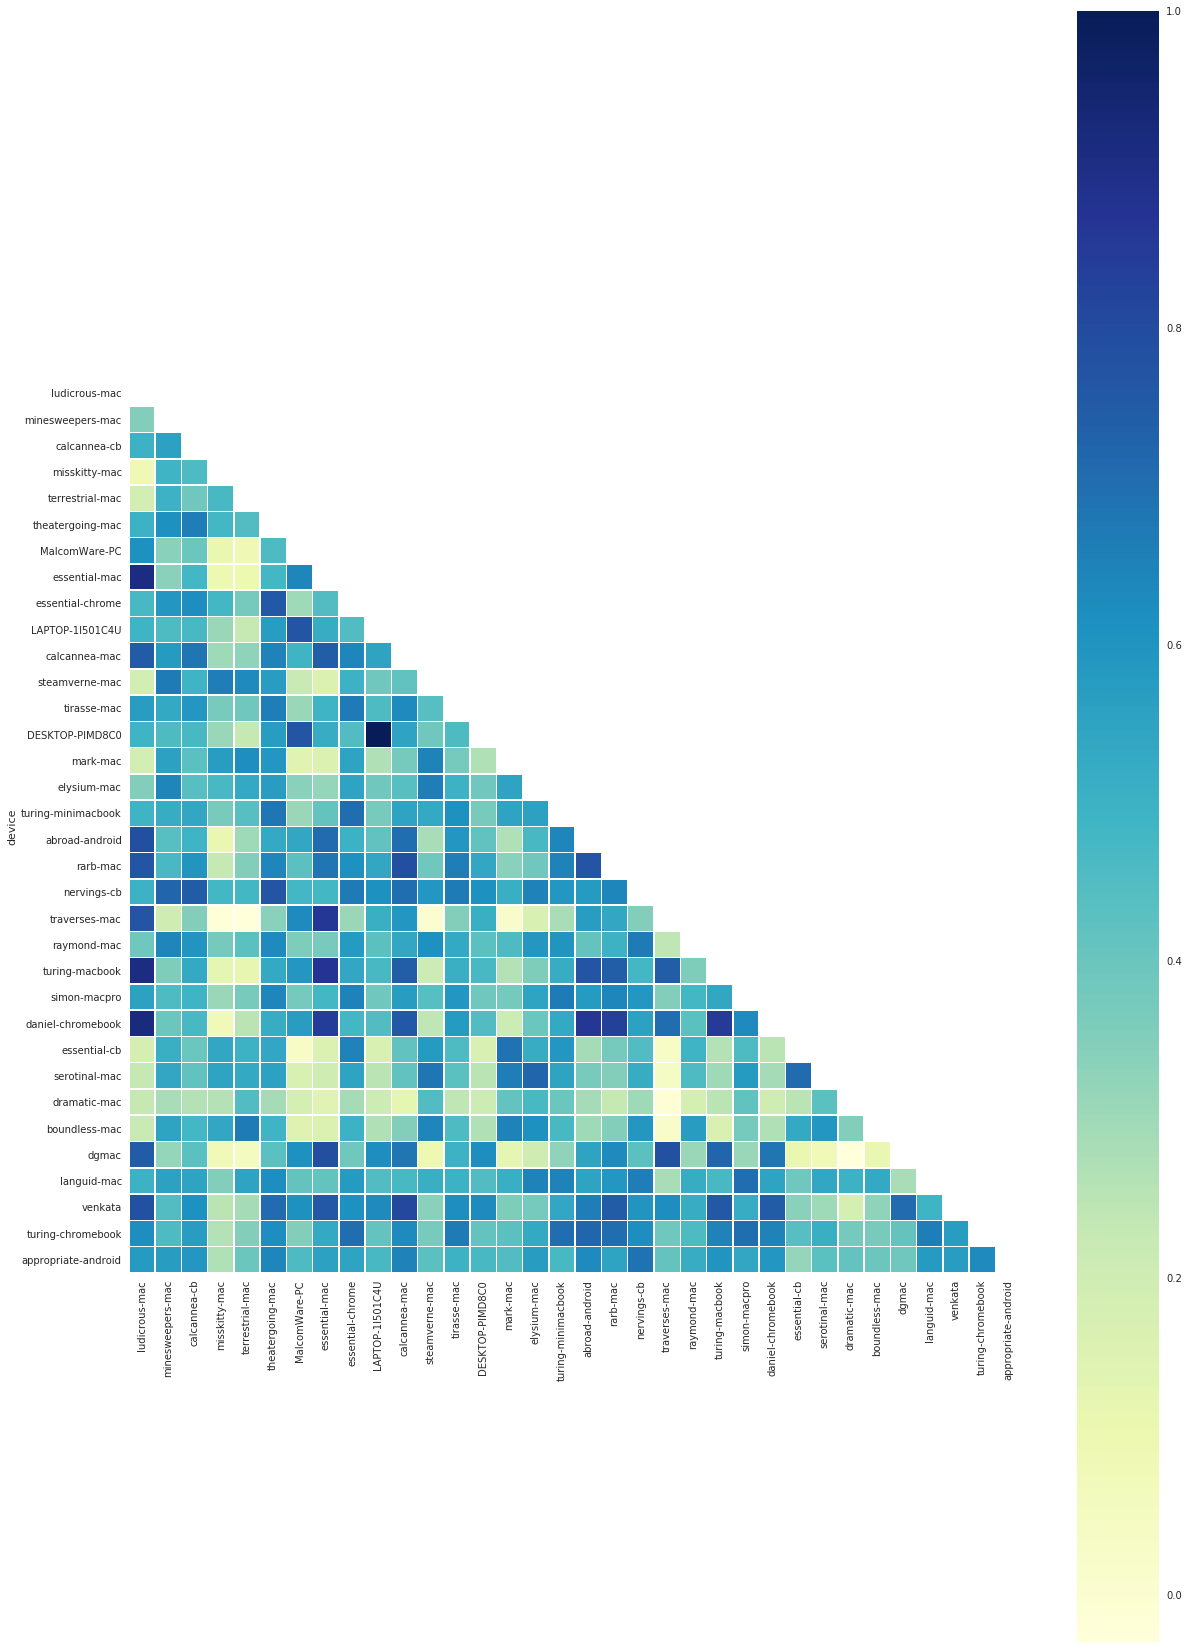

In [18]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()

## Kendall Tau

In [19]:
# Calculate Rho on 2 lists
def correlator(a, b):

    n = max(len(a), len(b))
    
    alst = [v for v in range(0,len(a))]
    amap = {a[i]: i for i in range(0, len(a)) }
    blst = [amap[b[v]] if b[v] in amap else len(a) for v in range(0, len(b))]
    alst.extend([len(a)] * (n - len(a)))
    blst.extend([len(a)] * (n - len(b)))

    tau, p = stats.weightedtau(alst, blst)
  
    return tau

In [20]:
df3 = pd.DataFrame(fav_bls, columns=["device", "blacklists"]).set_index("device")
for dev, bls in everyone:
    df3[dev] = df3["blacklists"].apply(lambda x: correlator(bls, x)).round(2)
df3

,blacklists,ludicrous-mac,minesweepers-mac,calcannea-cb,misskitty-mac,terrestrial-mac,theatergoing-mac,MalcomWare-PC,essential-mac,essential-chrome,...,daniel-chromebook,essential-cb,serotinal-mac,dramatic-mac,boundless-mac,dgmac,languid-mac,venkata,turing-chromebook,appropriate-android
device,,,,,,,,,,,,,,,,,,,,,
ludicrous-mac,"[facebook.588498724619612.IN5, facebook.393520...",1.00,0.44,0.62,0.07,0.01,0.58,0.74,0.91,0.54,...,0.93,-0.03,0.09,0.03,0.17,0.82,0.49,0.82,0.67,0.62
minesweepers-mac,"[facebook.393520067497631.IN7, facebook.588498...",0.44,1.00,0.61,0.38,0.08,0.66,0.50,0.47,0.58,...,0.51,0.28,0.42,0.20,0.46,0.44,0.59,0.52,0.51,0.63
calcannea-cb,"[facebook.393520067497631.IN7, facebook.588498...",0.62,0.61,1.00,0.25,0.12,0.69,0.62,0.58,0.67,...,0.59,0.27,0.37,0.24,0.25,0.59,0.64,0.63,0.65,0.66
misskitty-mac,"[facebook.588498724619612.IN5, vt.1fddca25aa57...",0.07,0.38,0.25,1.00,0.32,0.23,0.12,0.06,0.22,...,0.12,0.38,0.48,0.24,0.53,0.08,0.23,0.13,0.12,0.12
terrestrial-mac,"[facebook.588498724619612.IN5, facebook.393520...",0.01,0.08,0.12,0.32,1.00,0.17,0.04,0.00,0.05,...,0.14,0.32,0.37,0.19,0.47,-0.01,0.22,0.12,-0.01,0.06
theatergoing-mac,"[facebook.588498724619612.IN5, facebook.393520...",0.58,0.66,0.69,0.23,0.17,1.00,0.64,0.58,0.77,...,0.64,0.29,0.49,0.23,0.25,0.59,0.66,0.73,0.69,0.72
MalcomWare-PC,"[facebook.393520067497631.IN7, vt.ccb444a57661...",0.74,0.50,0.62,0.12,0.04,0.64,1.00,0.77,0.53,...,0.74,-0.05,0.15,0.13,0.18,0.78,0.50,0.76,0.57,0.67
essential-mac,"[facebook.393520067497631.IN7, facebook.588498...",0.91,0.47,0.58,0.06,0.00,0.58,0.77,1.00,0.57,...,0.86,-0.01,0.11,0.03,0.16,0.87,0.54,0.82,0.65,0.65
essential-chrome,"[facebook.588498724619612.IN5, facebook.393520...",0.54,0.58,0.67,0.22,0.05,0.77,0.53,0.57,1.00,...,0.63,0.39,0.43,0.26,0.24,0.47,0.63,0.67,0.74,0.61


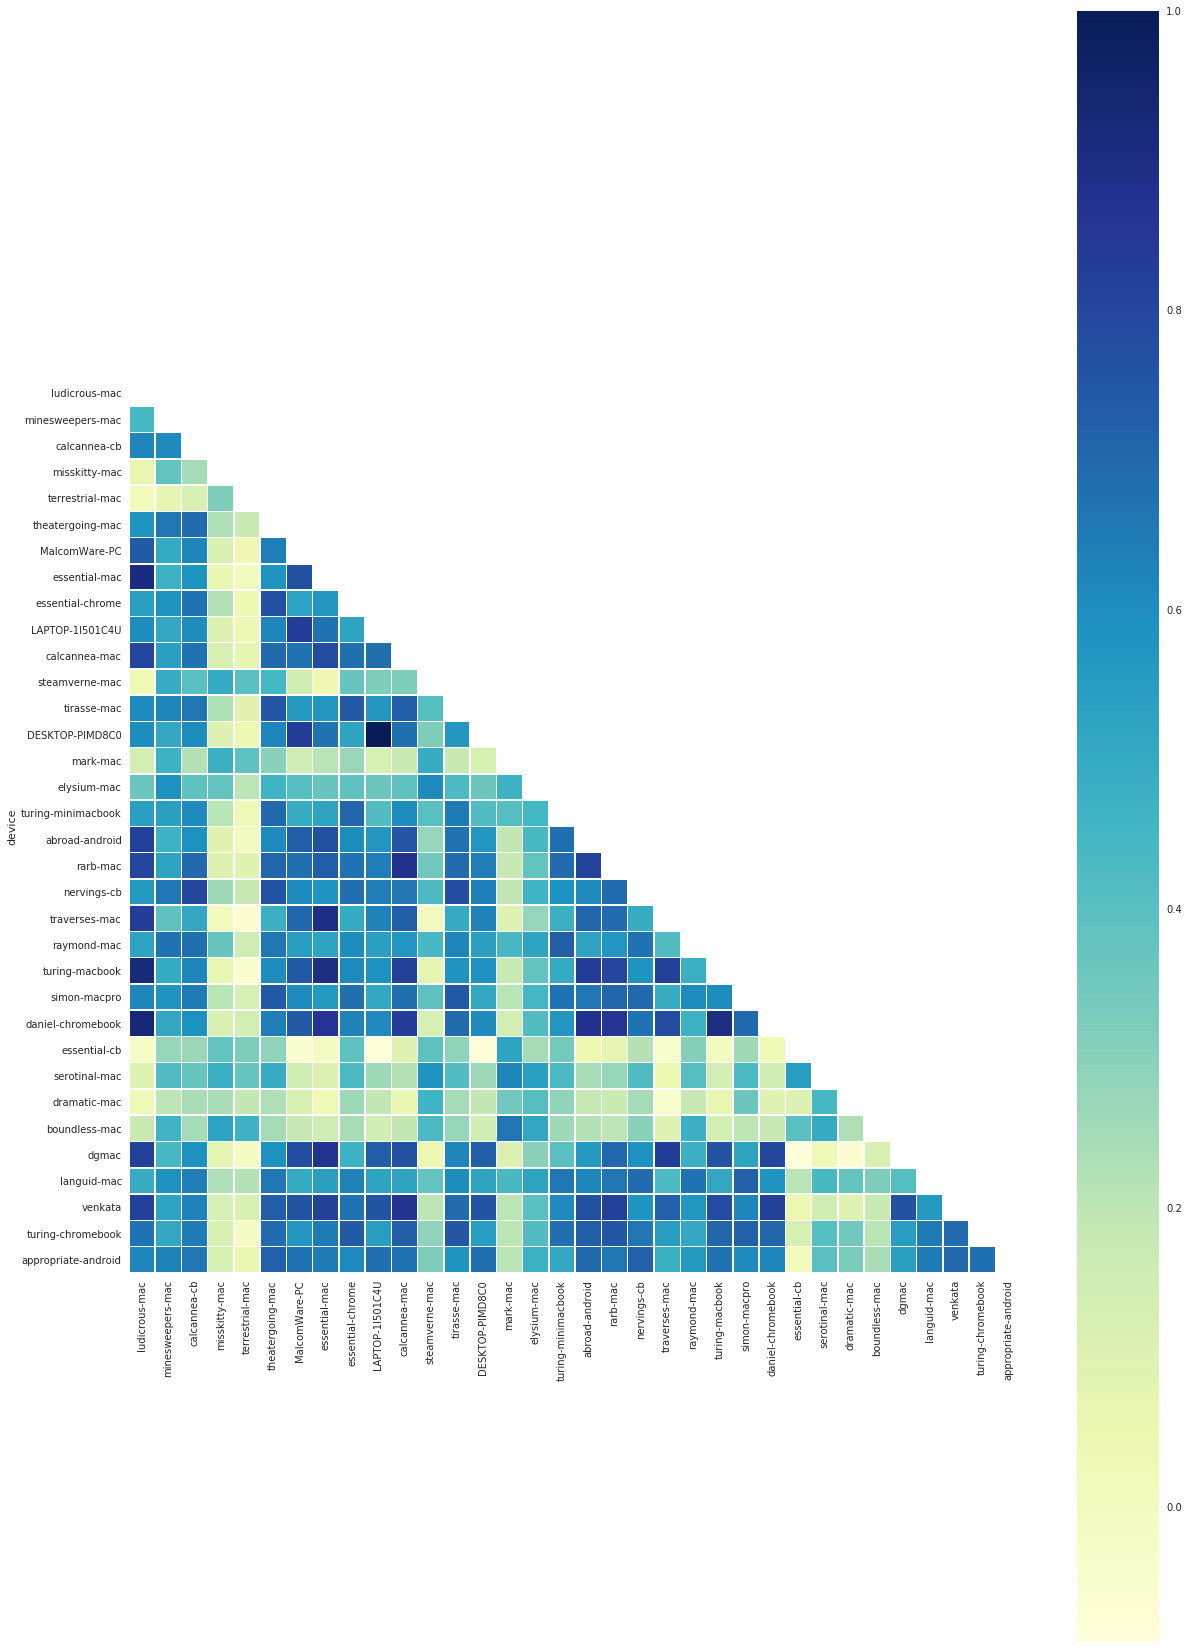

In [21]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()